In [35]:
from dataset import transform
from visualize import visualize_point_cloud_comparison, visualize_point_cloud
from dataset.shapenetcore import ShapeNetCore
import torch

# create an input transform with 50% points removed and 2% noise
input_transform = transform.RandomTransform(removal_amount=0, noise_amount=0.05, noise_type="gaussian", task="completion")

# create the dataset (use 2048 for better visualization, but 1024 when training)
train_data = ShapeNetCore(
    root="Shapenetcore_benchmark",
    split="train",
    max_points=2048,
    input_transform=input_transform, 
    use_rotations=False
)

In [33]:

# y = train_data[3000][-1]
# for noise_level in [0, 0.01, 0.03, 0.05, 0.075, 0.1]:
#     x = transform.add_noise(y, noise_type="gaussian", amount=noise_level)
#     visualize_point_cloud(x)

In [41]:
# y = train_data[3000][-1]
# import torch
# torch.manual_seed(0)
# for removal_level in [0, 0.10, 0.20, 0.40, 0.5, 0.75]:
#     x = transform.remove_neighboring_points(y, int(x.shape[0] * removal_level))
#     visualize_point_cloud(x)

tensor([[ 0.0296,  0.0078,  0.4106],
        [-0.0316, -0.0175,  0.6120],
        [ 0.1119,  0.1128,  0.0038],
        ...,
        [-0.1261, -0.1324, -0.8287],
        [ 0.0476,  0.0627,  0.1005],
        [-0.0095, -0.0056, -0.0970]])

In [7]:


visualize_point_cloud(
    train_data[800][-1]
)
print(train_data[700][-1].shape)
# visualize_point_cloud_comparison(
#     dataset=train_data,
#     class_label="Airplane"
# )

torch.Size([2048, 3])


In [49]:
torch.get_rng_state()

tensor([187,  89, 195,  ...,   0,   0,   0], dtype=torch.uint8)

In [53]:
torch.seed()

3064258705167746337

In [103]:
# get name of top two models
# top_two_models = results_df.iloc[results_df["avg_chamf_dist"].sort_values().index]["model"][:2].tolist()
from visualize import visualize_point_cloud_comparison
from dataset import transform
from dataset.shapenetcore import ShapeNetCore
import torch

from pathlib import Path
from torch.utils.data import DataLoader
from models.completion import CompletionTransformer
from models.denoiser import DenoiserTransformer
from models.conv import DenoiserConv
import time
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# saved model paths
model_paths = list(Path("checkpoints").glob("completion_transformer_*.pth"))
# print saved model paths
print("Models saved to:")
for model_path in model_paths:
    print(model_path)
    
    
for checkpoint_name in model_paths:

    # skip poor performing models
    # if Path(checkpoint_name).stem not in top_two_models:
    #     continue

    # load checkpoint
    state_dict = torch.load(
        f=checkpoint_name, map_location=device
    )

    # create data transform
    input_transform = transform.RandomTransform(
        removal_amount=state_dict["removal_amount"],
        noise_amount=state_dict["noise_amount"],
        noise_type=state_dict["noise_type"],
        task="completion",
    )

    # load test data
    test_data = ShapeNetCore(
        root="./Shapenetcore_benchmark",
        split="test",
        max_points=state_dict["max_points"],
        input_transform=input_transform
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=1,
        shuffle=True,
        num_workers=1,
        pin_memory=True
    )

    # # instantiate model
    # model = DenoiserTransformer(
    #     num_layers=state_dict["num_layers"],
    #     num_heads=state_dict["num_heads"],
    #     d_model=state_dict["d_model"],
    #     # num_queries=int(state_dict["max_points"] * state_dict["removal_amount"])
    #     # use_pos_embeddings=state_dict["use_pos_embeddings"]
    # ).to(device).eval()
    
    model = CompletionTransformer(
        num_layers=state_dict["num_layers"],
        num_heads=state_dict["num_heads"],
        d_model=state_dict["d_model"],
        num_queries=int(state_dict["max_points"] * state_dict["removal_amount"])
        # use_pos_embeddings=state_dict["use_pos_embeddings"]
    ).to(device).eval()

    # necessary if distributed training was used
    if all(key.startswith("module.") for key in state_dict["model"].keys()):
        model = nn.DataParallel(model)

    # load weights
    model.load_state_dict(state_dict["model"])

    # visualize
    visualize_point_cloud_comparison(
        dataset=test_data,
        class_label="Earphone",
        model=model,
        title=Path(checkpoint_name).stem
    )
    time.sleep(0.2)

Models saved to:
checkpoints/completion_transformer_1.pth


/tmp/ipykernel_273702/581169441.py:33: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [47]:
from models.completion import CompletionTransformer
from models.denoiser import DenoiserTransformer


completion_transformer_512 = CompletionTransformer(8, 512, 8, d_model=256)
completion_transformer_256 = CompletionTransformer(8, 256, 8, d_model=256)
denoiser_transformer = DenoiserTransformer(8, 8, d_model=256)
print(sum(p.numel() for p in completion_transformer_256.parameters()) / 1e6)
print(sum(p.numel() for p in completion_transformer_512.parameters()) / 1e6)
print(sum(p.numel() for p in denoiser_transformer.parameters()) / 1e6)


21.044483
21.831683
17.895939


In [3]:
import trimesh

# Load the .ply file
mesh = trimesh.load("synthetic_data/1381.ply")

# Visualize the mesh
mesh.show()


<trimesh.PointCloud(vertices.shape=(1024, 3), name=`1381.ply`)>


### Plot Training/Val Losses

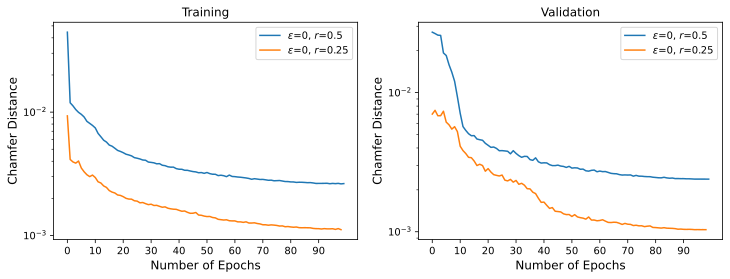

In [105]:
%config InlineBackend.figure_format = 'svg'
from pathlib import Path
from visualize import compare_train_val_losses

model_type = "completion_transformer"
model_paths = list(Path("checkpoints").glob(f"{model_type}_*.pth"))
compare_train_val_losses(model_paths)

In [11]:
import torch
from models.completion import CompletionTransformer
from models.denoiser import DenoiserTransformer
state_dict = torch.load("./checkpoints/denoiser_transformer_1.pth")
model = torch.nn.DataParallel(DenoiserTransformer(8, 8, d_model=256))
model.load_state_dict(state_dict["model"])
model = model.to("cuda")

/tmp/ipykernel_104871/3060774426.py:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [12]:
from dataset import transform
from dataset.shapenetcore import ShapeNetCore
# create data transform
input_transform = transform.RandomTransform(
    removal_amount=state_dict["removal_amount"],
    noise_amount=state_dict["noise_amount"],
    noise_type=state_dict["noise_type"],
    task="denoising",
)

# load test data
test_data = ShapeNetCore(
    root="./Shapenetcore_benchmark",
    split="test",
    max_points=state_dict["max_points"],
    input_transform=input_transform
)

In [77]:
from visualize import visualize_point_cloud_comparison
visualize_point_cloud_comparison(test_data, "Chair", model, 10)

Dataset index: 2289


In [46]:
import torch
from visualize import visualize_point_cloud
from dataset.transform import normalize_point_cloud

ex = test_data[2289]
x, y = ex[-2], ex[-1]
pred = model(x.unsqueeze(0).cuda()).squeeze(0).cpu().detach()
# pred = normalize_point_cloud(pred)
# x = normalize_point_cloud(x)
# offset = torch.tensor([0, 0, 1])
# pred = pred + offset
# point_cloud_agg = torch.cat([x, pred.squeeze(0)], dim=0).numpy()
# visualize_point_cloud(point_cloud_agg)
create_gif(pred, x, name="animation_5.gif")

/tmp/ipykernel_104871/2057835300.py:76: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [1]:
import numpy as np

In [2]:
import numpy as np
import plotly.graph_objects as go
import imageio
from plotly.subplots import make_subplots

def create_gif(p1, p2, num_frames: int = 60, name: str = "point_cloud.gif"):
    rotation_degrees = 360 / num_frames
    gif_frames = []

    # Create subplots with 2 rows, stacked vertically
    fig = make_subplots(
        rows=2, cols=1,
        specs=[[{'type': 'scatter3d'}], [{'type': 'scatter3d'}]],
        vertical_spacing=0
    )

    # Add the first point cloud to the first subplot
    fig.add_trace(
        go.Scatter3d(
            x=p1[:, 0], y=p1[:, 1], z=p1[:, 2],
            mode='markers',
            marker=dict(size=1.5, color='red'),
            showlegend=False
        ),
        row=1, col=1,
    )

    # Add the second point cloud to the second subplot
    fig.add_trace(
        go.Scatter3d(
            x=p2[:, 0], y=p2[:, 1], z=p2[:, 2],
            mode='markers',
            marker=dict(size=1.5, color='blue'),
            showlegend=False
        ),
        row=2, col=1
    )

    # Set the layout for both scenes (subplots)
    fig.update_layout(
        scene=dict(
            aspectmode="data",
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        ),
        scene2=dict(
            aspectmode="data",
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        ),
        height=800,  # Increase height to fit both subplots
        autosize=True
    )
    

    # Generate frames for each rotation angle
    for i in range(num_frames):
        # Rotate view for both subplots
        fig.update_layout(
            scene_camera=dict(
                eye=dict(x=2 * np.cos(np.radians(i * rotation_degrees)),
                         y=2 * np.sin(np.radians(i * rotation_degrees)),
                         z=0.5)
            ),
            scene2_camera=dict(
                eye=dict(x=2 * np.cos(np.radians(i * rotation_degrees)),
                         y=2 * np.sin(np.radians(i * rotation_degrees)),
                         z=0.5)
            )
        )

        # Capture the plot as an image
        img_bytes = fig.to_image(format="png", width=600, height=800)
        gif_frames.append(imageio.imread(img_bytes))
        
    fig.plotly_restyle({'visible': False}, [0])

    # Save frames as a looping GIF
    imageio.mimsave(name, gif_frames, fps=10, loop=0)

# Example usage
p1 = np.random.rand(100, 3)
p2 = np.random.rand(100, 3)
create_gif(p1, p2)


/tmp/ipykernel_104871/2057835300.py:76: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

